In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


## importing libraries

In [2]:
import keras
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

## extracting files

In [3]:
%%time
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip",'r') as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip",'r') as z:
    z.extractall(".")

CPU times: user 8.11 s, sys: 2.56 s, total: 10.7 s
Wall time: 19.5 s


In [4]:
filenames = os.listdir('/kaggle/working/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head() , df.tail()

(        filename category
 0    cat.607.jpg        0
 1   dog.6400.jpg        1
 2  dog.10509.jpg        1
 3   dog.7843.jpg        1
 4   cat.9702.jpg        0,
             filename category
 24995   cat.5212.jpg        0
 24996   cat.8014.jpg        0
 24997  cat.10660.jpg        0
 24998   cat.3661.jpg        0
 24999   dog.6895.jpg        1)

In [6]:
df['category'].value_counts()


0    12500
1    12500
Name: category, dtype: int64

## visualizing data

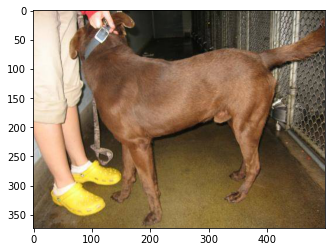

In [7]:

sample = random.choice(filenames)
image = load_img("/kaggle/working/train/"+sample)
plt.imshow(image)

## splitting of dataset

In [8]:

train_data, valid_data = train_test_split(df, test_size=0.2, random_state = 42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## generating training data

In [9]:

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [10]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
)

Found 20000 validated image filenames belonging to 2 classes.


## generating validation data

In [11]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(valid_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
)

Found 5000 validated image filenames belonging to 2 classes.


# *CNN Model*

In [12]:
model = keras.models.Sequential([
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=(128,128,3)),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Flatten(),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.25),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.25),                        
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.10),                         
                         keras.layers.Dense(units=2, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [14]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

## training model

In [15]:
model.fit(train_generator, epochs=15, verbose=1, validation_data=valid_generator)

Epoch 1/15
1334/1334 [==============================] - 157s 115ms/step - loss: 0.6929 - accuracy: 0.5172 - val_loss: 0.6868 - val_accuracy: 0.5422
Epoch 2/15
1334/1334 [==============================] - 150s 112ms/step - loss: 0.6790 - accuracy: 0.5784 - val_loss: 0.6697 - val_accuracy: 0.5806
Epoch 3/15
1334/1334 [==============================] - 151s 113ms/step - loss: 0.6631 - accuracy: 0.6000 - val_loss: 0.5942 - val_accuracy: 0.6924
Epoch 4/15
1334/1334 [==============================] - 149s 112ms/step - loss: 0.6051 - accuracy: 0.6778 - val_loss: 0.5676 - val_accuracy: 0.6990
Epoch 5/15
1334/1334 [==============================] - 153s 115ms/step - loss: 0.5648 - accuracy: 0.7107 - val_loss: 0.5929 - val_accuracy: 0.7082
Epoch 6/15
1334/1334 [==============================] - 153s 115ms/step - loss: 0.5434 - accuracy: 0.7306 - val_loss: 0.5042 - val_accuracy: 0.7512
Epoch 7/15
1334/1334 [==============================] - 156s 117ms/step - loss: 0.5230 - accuracy: 0.7474 - val_

In [16]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
idlist=[]
for file in test_df["filename"]:
    idlist.append(file.split(".")[0])

#test_df['ids'] = alist
nb_samples = test_df.shape[0]

## generating test data

In [17]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=15,
    shuffle=False
)

Found 12500 validated image filenames.


## predicting model

In [18]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/15))

In [19]:
test_df['category'] = np.argmax(predict, axis=-1)

In [20]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [21]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## submission

In [22]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)